In [69]:
import os
os.environ["KAGGLE_USERNAME"] = "filipedanielmota"
os.environ["KAGGLE_KEY"] = "2314b79815678fef0b557ec736c2a3b3"

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import  matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import numpy as np
import pandas as pd
import os

# Baixar a última versão do dataset
path = kagglehub.dataset_download("adampq/pokemon-tcg-all-cards-1999-2023")

# Especificar o nome do arquivo dentro do diretório extraído
file_name = "pokemon-tcg-data-master 1999-2023.csv"  # Substitua pelo nome correto do arquivo
file_path = os.path.join(path, file_name)

# Carregar o arquivo como DataFrame do Pandas
df = pd.read_csv(file_path)

# Remover as colunas especificadas
columns_to_remove = [
    "id", "set", "series", "publisher", "release_date", "artist", "evolvesFrom", "evolvesTo",
    "name","abilities", "nationalPokedexNumbers", "set_num", "rules","flavorText", "regulationMark", "ancientTrait"
]
df = df.drop(columns=columns_to_remove)

generation_mapping = {
    'first': 1,
    'second': 2,
    'third': 3,
    'fourth': 4,
    'fifth': 5,
    'sixth': 6,
    'seventh': 7,
    'eighth': 8,
    'ninth': 9
}

df['generation'] = df['generation'].str.lower().map(generation_mapping)

# Filtrar apenas linhas onde 'supertype' é 'Pokemon'
df = df[df['supertype'] == 'Pokémon']

# Resetar o índice após o filtro (opcional, mas recomendável)
df = df.reset_index(drop=True)

# Exibir as primeiras linhas após as transformações
print("DataFrame após transformações:")
print(df.head())

DataFrame após transformações:
   generation          types supertype     subtypes level     hp  \
0         1.0    ['Psychic']   Pokémon  ['Stage 2']    42   80.0   
1         1.0      ['Water']   Pokémon  ['Stage 2']    52  100.0   
2         1.0  ['Colorless']   Pokémon    ['Basic']    55  120.0   
3         1.0       ['Fire']   Pokémon  ['Stage 2']    76  120.0   
4         1.0  ['Colorless']   Pokémon    ['Basic']    14   40.0   

                                             attacks  \
0  [{'name': 'Confuse Ray', 'cost': ['Psychic', '...   
1  [{'name': 'Hydro Pump', 'cost': ['Water', 'Wat...   
2  [{'name': 'Scrunch', 'cost': ['Colorless', 'Co...   
3  [{'name': 'Fire Spin', 'cost': ['Fire', 'Fire'...   
4  [{'name': 'Sing', 'cost': ['Colorless'], 'conv...   

                               weaknesses  \
0    [{'type': 'Psychic', 'value': '×2'}]   
1  [{'type': 'Lightning', 'value': '×2'}]   
2   [{'type': 'Fighting', 'value': '×2'}]   
3      [{'type': 'Water', 'value': '×2'}]  

In [70]:
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14497 entries, 0 to 14496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   generation            13820 non-null  float64
 1   types                 14497 non-null  object 
 2   supertype             14497 non-null  object 
 3   subtypes              14497 non-null  object 
 4   level                 2404 non-null   object 
 5   hp                    14497 non-null  float64
 6   attacks               14466 non-null  object 
 7   weaknesses            14094 non-null  object 
 8   retreatCost           13678 non-null  object 
 9   convertedRetreatCost  13678 non-null  float64
 10  rarity                14262 non-null  object 
 11  legalities            14497 non-null  object 
 12  resistances           4281 non-null   object 
dtypes: float64(3), object(10)
memory usage: 1.4+ MB
None
         generation            hp  convertedRetreatCost
count  13820

In [71]:
# prompt: preciso que o conteúdo da minha variável subtypes saia do formato de lista e fique apenas o conteúdo em string e adicione um print do df para eu conseguir visualizar a base

df['subtypes'] = df['subtypes'].apply(lambda x: ', '.join(eval(x)) if isinstance(x, str) else '')

print("\nDataFrame após a transformação da coluna 'subtypes':")
print(df.head())





DataFrame após a transformação da coluna 'subtypes':
   generation          types supertype subtypes level     hp  \
0         1.0    ['Psychic']   Pokémon  Stage 2    42   80.0   
1         1.0      ['Water']   Pokémon  Stage 2    52  100.0   
2         1.0  ['Colorless']   Pokémon    Basic    55  120.0   
3         1.0       ['Fire']   Pokémon  Stage 2    76  120.0   
4         1.0  ['Colorless']   Pokémon    Basic    14   40.0   

                                             attacks  \
0  [{'name': 'Confuse Ray', 'cost': ['Psychic', '...   
1  [{'name': 'Hydro Pump', 'cost': ['Water', 'Wat...   
2  [{'name': 'Scrunch', 'cost': ['Colorless', 'Co...   
3  [{'name': 'Fire Spin', 'cost': ['Fire', 'Fire'...   
4  [{'name': 'Sing', 'cost': ['Colorless'], 'conv...   

                               weaknesses  \
0    [{'type': 'Psychic', 'value': '×2'}]   
1  [{'type': 'Lightning', 'value': '×2'}]   
2   [{'type': 'Fighting', 'value': '×2'}]   
3      [{'type': 'Water', 'value': '×2'}]   

In [ ]:
# prompt: agora na minha coluna subtypes preciso que você deixe apenas o conteúdo seguindo a hierarquia:
# basic < stage 1 < stage 2 < LEGEND < Ancient
# se na lista tiver algo como 'SP', 'Prime' ou outra coisa que fuja dessa hierarquia, pode remover e deixar apenas o conteudo seguindo a hieraquia
# ATENÇÃO: DURANTE ESSE PROCESSO DE FILTRO EU PRECISO QUE VOCÊ CRIA DAS NOVAS VARIÁVEIS CHAMADAS 'EX' E 'GX'. DURANTE O FILTRO SE NESSAS LISTAS CONTER EX OU GX VOCÊ IRA ACRESCENTAR O VALOR 1 PARA OS DADOS QUE CONTIVEREM E 0 PARA OS DADOS QUE NÃO CONTIVEREM

# Hierarquia desejada
hierarchy = ['Basic', 'Stage 1', 'Stage 2', 'LEGEND', 'Ancient']

# Função para filtrar e ordenar os subtipos
def filter_subtypes(subtypes_str):
    if not subtypes_str:
        return ''
    # Converte a string de subtipos em uma lista
    subtypes_list = [sub.strip() for sub in subtypes_str.split(',')]
    # Filtra para manter apenas os subtipos da hierarquia
    filtered = [sub for sub in subtypes_list if sub in hierarchy]
    # Ordena os subtipos de acordo com a hierarquia
    ordered = sorted(filtered, key=lambda x: hierarchy.index(x))
    return ', '.join(ordered)

# Aplica a função para filtrar e ordenar a coluna 'subtypes'
df['subtypes'] = df['subtypes'].apply(filter_subtypes)

# Cria as novas colunas 'EX' e 'GX'
# Verifica se 'EX' está na lista original de subtipos (antes de filtrar e ordenar)
df['EX'] = df['subtypes'].apply(lambda x: 1 if 'EX' in [sub.strip() for sub in (x.split(',') if x else '')] else 0)
# Verifica se 'GX' está na lista original de subtipos (antes de filtrar e ordenar)
df['GX'] = df['subtypes'].apply(lambda x: 1 if 'GX' in [sub.strip() for sub in (x.split(',') if x else '')] else 0)


print("\nDataFrame após filtrar e ordenar a coluna 'subtypes' e adicionar 'EX'/'GX':/n")
print(df)

<ipython-input-8-2a6815ac24fc>:3: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


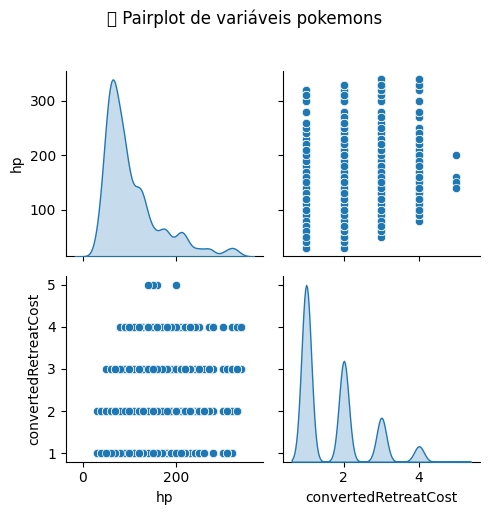

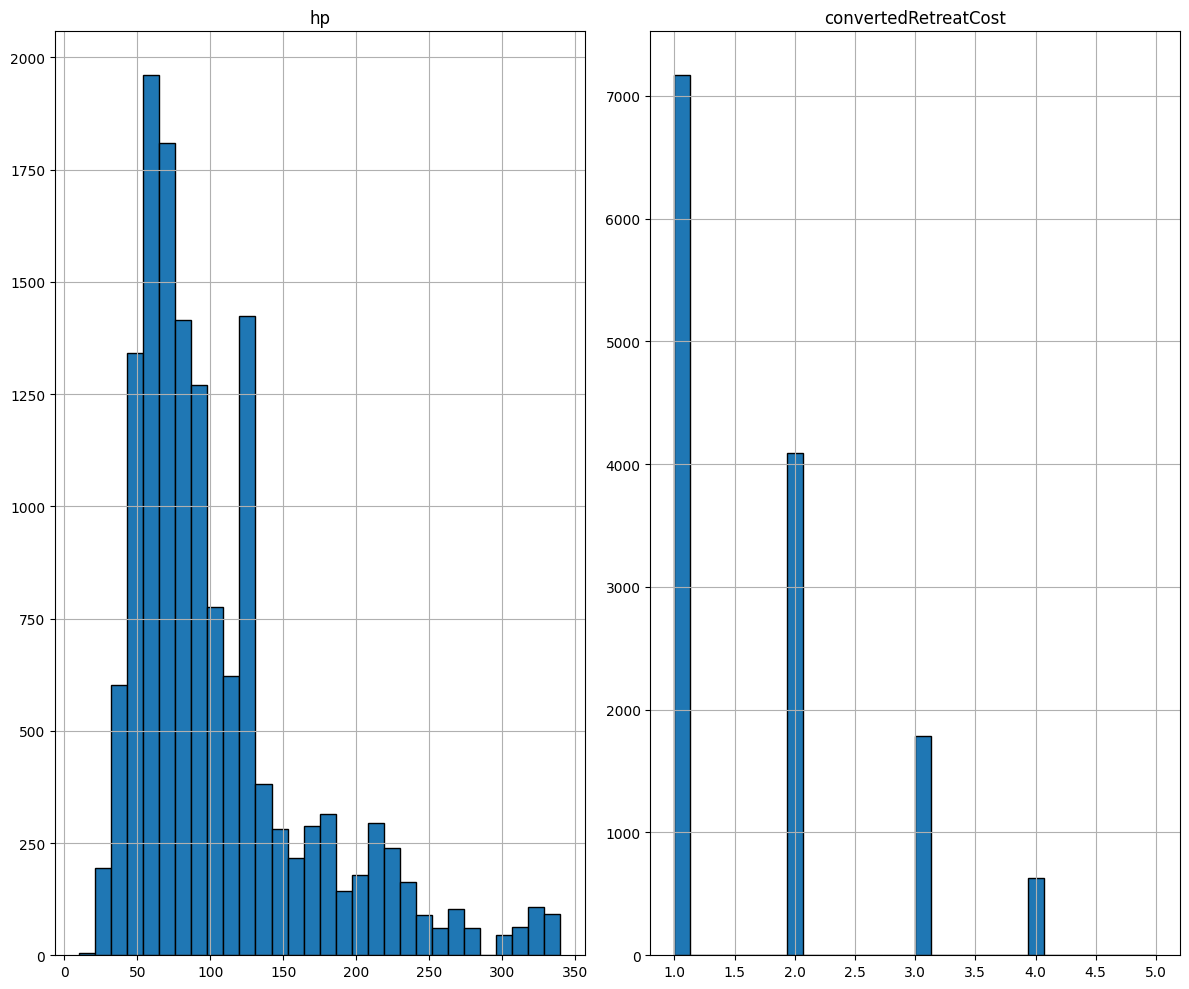

In [8]:
sns.pairplot(df[['generation','types','supertype','subtypes','level','hp','evolvesTo','evolvesFrom','abilities','attacks','weaknesses','retreatCost','convertedRetreatCost','rarity','nationalPokedexNumbers','legalities','resistances','rules']], diag_kind="kde")
plt.suptitle("🔍 Pairplot de variáveis pokemons", y=1.02)
plt.tight_layout()
plt.show()

df.hist(bins=30, figsize=(12, 10), edgecolor='black')
plt.tight_layout()
plt.show()